In [1]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
import os
import yfinance as yf
# Добавление технических индекаторов
from ta import add_all_ta_features
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score

In [2]:
# загружаем данные
os.chdir(r'd:\ml\временные ряды')
data = pd.read_csv("SBER_210301_240508.csv", delimiter =';')

In [3]:
data.head()

,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL
0,SBER,D,01/03/21,0,273.00,274.73,271.13,273.58,35741070
1,SBER,D,02/03/21,0,271.89,280.00,271.60,279.10,71481180
2,SBER,D,03/03/21,0,281.70,283.83,277.63,278.01,64113880
3,SBER,D,04/03/21,0,278.53,281.96,273.63,274.75,91841080
4,SBER,D,05/03/21,0,276.12,278.98,272.76,277.50,83301590


In [4]:
data = add_all_ta_features(data, 
                         open="OPEN", high="HIGH", 
                         low="LOW", close="CLOSE", 
                         volume="VOL", fillna=True)
data.head()

,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,volume_adi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,SBER,D,01/03/21,0,273.00,274.73,271.13,273.58,35741070,1.290650e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,273.580000,0.000000,0.000000,0.000000
1,SBER,D,02/03/21,0,271.89,280.00,271.60,279.10,71481180,6.907028e+07,...,0.160715,0.032143,0.128572,7.426870,1.485374,5.941496,274.884674,2.017691,1.997606,2.017691
2,SBER,D,03/03/21,0,281.70,283.83,277.63,278.01,64113880,1.281552e+07,...,0.252790,0.076272,0.176518,11.080057,3.404311,7.675747,275.636231,-0.390541,-0.391306,1.619270
3,SBER,D,04/03/21,0,278.53,281.96,273.63,274.75,91841080,-5.432880e+07,...,0.227344,0.106487,0.120857,17.885587,6.300566,11.585021,275.412481,-1.172620,-1.179549,0.427663
4,SBER,D,05/03/21,0,276.12,278.98,272.76,277.50,83301590,-1.066912e+07,...,0.284566,0.142103,0.142464,20.848870,9.210227,11.638643,275.809684,1.000910,0.995934,1.432853


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 793 entries, 0 to 792
Data columns (total 95 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   TICKER                     793 non-null    object 
 1   PER                        793 non-null    object 
 2   DATE                       793 non-null    object 
 3   TIME                       793 non-null    int64  
 4   OPEN                       793 non-null    float64
 5   HIGH                       793 non-null    float64
 6   LOW                        793 non-null    float64
 7   CLOSE                      793 non-null    float64
 8   VOL                        793 non-null    int64  
 9   volume_adi                 793 non-null    float64
 10  volume_obv                 793 non-null    int64  
 11  volume_cmf                 793 non-null    float64
 12  volume_fi                  793 non-null    float64
 13  volume_em                  793 non-null    float64

После добавления технических индекаторов, количество признаков OPEN, HIGH, LOW, CLOSE, VOL с 5 увеличилось до 92.
Готовим данные для модели. Сделаем целевую переменную - выросла цена или нет на следующий день 1 / 0

In [6]:
data["TARGET"] = 0
data.loc[data["CLOSE"].shift(-1) > data["CLOSE"], "TARGET"] = 1
data.head()

,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,volume_adi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
0,SBER,D,01/03/21,0,273.00,274.73,271.13,273.58,35741070,1.290650e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,273.580000,0.000000,0.000000,0.000000,1
1,SBER,D,02/03/21,0,271.89,280.00,271.60,279.10,71481180,6.907028e+07,...,0.032143,0.128572,7.426870,1.485374,5.941496,274.884674,2.017691,1.997606,2.017691,0
2,SBER,D,03/03/21,0,281.70,283.83,277.63,278.01,64113880,1.281552e+07,...,0.076272,0.176518,11.080057,3.404311,7.675747,275.636231,-0.390541,-0.391306,1.619270,0
3,SBER,D,04/03/21,0,278.53,281.96,273.63,274.75,91841080,-5.432880e+07,...,0.106487,0.120857,17.885587,6.300566,11.585021,275.412481,-1.172620,-1.179549,0.427663,1
4,SBER,D,05/03/21,0,276.12,278.98,272.76,277.50,83301590,-1.066912e+07,...,0.142103,0.142464,20.848870,9.210227,11.638643,275.809684,1.000910,0.995934,1.432853,1


In [7]:
# Удалим столбцы с типом object из df
data.drop(['TICKER', 'PER', 'DATE', 'TIME'], axis= 1 , inplace= True )
data.head()

,OPEN,HIGH,LOW,CLOSE,VOL,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
0,273.00,274.73,271.13,273.58,35741070,1.290650e+07,35741070,0.361111,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,273.580000,0.000000,0.000000,0.000000,1
1,271.89,280.00,271.60,279.10,71481180,6.907028e+07,107222250,0.644179,3.945761e+08,33.726360,...,0.032143,0.128572,7.426870,1.485374,5.941496,274.884674,2.017691,1.997606,2.017691,0
2,281.70,283.83,277.63,278.01,64113880,1.281552e+07,43108370,0.074798,3.282247e+08,47.674544,...,0.076272,0.176518,11.080057,3.404311,7.675747,275.636231,-0.390541,-0.391306,1.619270,0
3,278.53,281.96,273.63,274.75,91841080,-5.432880e+07,-48732710,-0.206434,2.385637e+08,-26.620495,...,0.106487,0.120857,17.885587,6.300566,11.585021,275.412481,-1.172620,-1.179549,0.427663,1
4,276.12,278.98,272.76,277.50,83301590,-1.066912e+07,34568880,-0.030793,2.372088e+08,-14.373675,...,0.142103,0.142464,20.848870,9.210227,11.638643,275.809684,1.000910,0.995934,1.432853,1


Разделим данные на признаки (X) и целевую переменную (y), выполним стандартизацию признаков и разделим на обучающий и тестовый выборки:

In [8]:
# Признаки
X = data.iloc[:, :-1] # все строки и все столбцы кроме последнего столбца ["TARGET"]
# Целевой признак
y = data.iloc[:, -1] # выбираем последний столбец ["TARGET"]

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Определение метрик для оценки
scoring = {'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted'),
           'accuracy': make_scorer(accuracy_score)}

# Инициализация модели
model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=5)

# Создание стратифицированных фолдов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполнение кросс-валидации с оценкой
cv_results = cross_validate(model, X_train_scaled, y_train, cv=skf, scoring=scoring)

# Вычисление средних значений метрик
avg_precision = np.mean(cv_results['test_precision'])
avg_recall = np.mean(cv_results['test_recall'])
avg_f1_score = np.mean(cv_results['test_f1_score'])
avg_accuracy = np.mean(cv_results['test_accuracy'])

# Вычисление среднего времени обучения
avg_train_time = np.mean(cv_results['fit_time'])

# Вывод результатов
print("Среднее значение precision на кросс-валидации:", avg_precision)
print("Среднее значение recall на кросс-валидации:", avg_recall)
print("Среднее значение F1-score на кросс-валидации:", avg_f1_score)
print("Среднее значение accuracy на кросс-валидации:", avg_accuracy)
print("Среднее время обучения на одну модель:", avg_train_time, "секунд")

Среднее значение precision на кросс-валидации: 0.5374450754790002
Среднее значение recall на кросс-валидации: 0.5410573678290213
Среднее значение F1-score на кросс-валидации: 0.5334491305743905
Среднее значение accuracy на кросс-валидации: 0.5410573678290213
Среднее время обучения на одну модель: 0.28375940322875975 секунд


In [10]:
from sklearn.metrics import classification_report

# Обучение модели на тренировочных данных
model.fit(X_train_scaled, y_train)

# Прогнозирование меток классов для тренировочных и тестовых данных
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Вывод отчета классификации
print('Прогнозирование меток классов для тренировочных данных:', classification_report(y_train, y_train_pred), sep='\n')
print('---' * 20)
print('Прогнозирование меток классов для тестовых данных:', classification_report(y_test, y_test_pred), sep='\n')

Прогнозирование меток классов для тренировочных данных:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       298
           1       0.82      0.92      0.87       336

    accuracy                           0.85       634
   macro avg       0.86      0.85      0.85       634
weighted avg       0.86      0.85      0.85       634

------------------------------------------------------------
Прогнозирование меток классов для тестовых данных:
              precision    recall  f1-score   support

           0       0.49      0.39      0.43        75
           1       0.54      0.64      0.59        84

    accuracy                           0.52       159
   macro avg       0.52      0.51      0.51       159
weighted avg       0.52      0.52      0.51       159



На тестовых данных средние значения метрик precision, recall, F1-score, accuracy) на кросс-валидации составляют около 0.5
Строим матрицу ошибок для визуализации предсказаний модели

Применим PCA для уменьшения размерности данных и обучим модель RandomForest на преобразованных данных:
Импортируем PCA из модуля sklearn.decomposition, обучим PCA и визуализируем информацию о компонентах

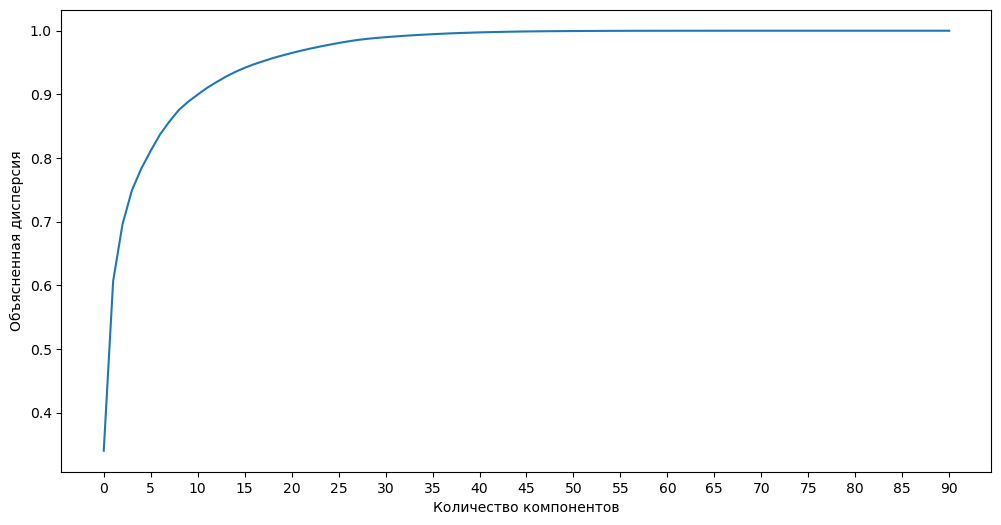

In [11]:
from sklearn.decomposition import PCA

plt.figure(figsize=(12, 6))  # Устанавливаем размер фигуры

pca = PCA().fit(X_train_scaled)
n_components = pca.explained_variance_ratio_.shape[0]

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, n_components + 1, step=5))  # Устанавливаем шаг на оси X
plt.xlabel('Количество компонентов')
plt.ylabel('Объясненная дисперсия')
plt.show()

По графику видно, что 15 компонетов уже обеспечивают порядка 90% информации в данных. Оставим эти 15 компонентов для обучения модели

In [12]:
# Установим важные компоненты:
components = 20

# Применим преобразование метода главных компонент 
# к стандартизированным данным, 
# уменьшая их размерность до количества компонент(десяти)

pca = PCA(n_components=components)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.fit_transform(X_test_scaled)

# Вычисление дисперсии, объясненной главными компонентами
print("Дисперсия каждой компоненты: ", pca.explained_variance_ratio_)
print("\n Общая объясненная дисперсия: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Дисперсия каждой компоненты:  [0.33693792 0.24543987 0.10069843 0.07391212 0.05804917 0.03242025
 0.01863061 0.01806998 0.01485113 0.01194893 0.01079854 0.01019986
 0.00853089 0.00659292 0.0056946  0.005072   0.00420961 0.00399609
 0.00347301 0.00314124]

 Общая объясненная дисперсия:  97.27


In [13]:
# Определение метрик для оценки
scoring = {'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted'),
           'accuracy': make_scorer(accuracy_score)}

# Инициализация модели
model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=5)

# Создание стратифицированных фолдов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполнение кросс-валидации с оценкой
cv_results = cross_validate(model, X_pca_train, y_train, cv=skf, scoring=scoring)

# Вычисление средних значений метрик
avg_precision = np.mean(cv_results['test_precision'])
avg_recall = np.mean(cv_results['test_recall'])
avg_f1_score = np.mean(cv_results['test_f1_score'])
avg_accuracy = np.mean(cv_results['test_accuracy'])

# Вычисление среднего времени обучения
avg_train_time = np.mean(cv_results['fit_time'])

# Вывод результатов
print("Среднее значение precision на кросс-валидации:", avg_precision)
print("Среднее значение recall на кросс-валидации:", avg_recall)
print("Среднее значение F1-score на кросс-валидации:", avg_f1_score)
print("Среднее значение accuracy на кросс-валидации:", avg_accuracy)
print("Среднее время обучения на одну модель:",avg_train_time, "секунд")

Среднее значение precision на кросс-валидации: 0.5910985870507177
Среднее значение recall на кросс-валидации: 0.5915510561179852
Среднее значение F1-score на кросс-валидации: 0.5886456315443979
Среднее значение accuracy на кросс-валидации: 0.5915510561179852
Среднее время обучения на одну модель: 0.21114649772644042 секунд


In [14]:
from sklearn.metrics import classification_report

# Обучаем модель
model.fit(X_pca_train, y_train)

# Прогнозирование меток классов для тестовых данных
y_train_pred = model.predict(X_pca_train)
y_test_pred = model.predict(X_pca_test)

# Вывод отчета классификации
print('Прогнозирование меток классов для тренировочных данных:', classification_report(y_train, y_train_pred), sep='\n')
print('---' * 20)
print('Прогнозирование меток классов для тестовых данных:', classification_report(y_test, y_test_pred), sep='\n')


Прогнозирование меток классов для тренировочных данных:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       298
           1       0.83      0.89      0.86       336

    accuracy                           0.85       634
   macro avg       0.85      0.84      0.85       634
weighted avg       0.85      0.85      0.85       634

------------------------------------------------------------
Прогнозирование меток классов для тестовых данных:
              precision    recall  f1-score   support

           0       0.51      0.51      0.51        75
           1       0.56      0.56      0.56        84

    accuracy                           0.53       159
   macro avg       0.53      0.53      0.53       159
weighted avg       0.53      0.53      0.53       159



В данном случае применение PCA не привело к значительному улучшению качества модели, изменения в метриках незначительны и могут быть вызваны случайностью. Правда использовать данную модель для прогнозирования покупки/продажи акций нельзя

In [ ]:
Так как у нас временной ряд, попробуем разделить данные как во временном ряду , сначала тренировачные , потом тестовые

In [15]:
t_len = round(len(data)*0.8)
train_data = data[:t_len]
test_data = data[t_len:]

In [19]:
# Признаки
X_train = train_data.iloc[:, :-1] # все строки и все столбцы кроме последнего столбца ["TARGET"]
X_test =  test_data.iloc[:, :-1] # все строки и все столбцы кроме последнего столбца ["TARGET"]

# Целевой признак
y_train = train_data.iloc[:, -1] # выбираем последний столбец ["TARGET"]
y_test = test_data.iloc[:, -1] # выбираем последний столбец ["TARGET"]

# Стандартизация данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
# Определение метрик для оценки
scoring = {'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted'),
           'accuracy': make_scorer(accuracy_score)}

# Инициализация модели
model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=5)

# Создание стратифицированных фолдов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполнение кросс-валидации с оценкой
cv_results = cross_validate(model, X_train_scaled, y_train, cv=skf, scoring=scoring)

# Вычисление средних значений метрик
avg_precision = np.mean(cv_results['test_precision'])
avg_recall = np.mean(cv_results['test_recall'])
avg_f1_score = np.mean(cv_results['test_f1_score'])
avg_accuracy = np.mean(cv_results['test_accuracy'])

# Вычисление среднего времени обучения
avg_train_time = np.mean(cv_results['fit_time'])

# Вывод результатов
print("Среднее значение precision на кросс-валидации:", avg_precision)
print("Среднее значение recall на кросс-валидации:", avg_recall)
print("Среднее значение F1-score на кросс-валидации:", avg_f1_score)
print("Среднее значение accuracy на кросс-валидации:", avg_accuracy)
print("Среднее время обучения на одну модель:", avg_train_time, "секунд")


Среднее значение precision на кросс-валидации: 0.5213953018357853
Среднее значение recall на кросс-валидации: 0.5236970378702661
Среднее значение F1-score на кросс-валидации: 0.5195061274229884
Среднее значение accuracy на кросс-валидации: 0.5236970378702661
Среднее время обучения на одну модель: 0.29472956657409666 секунд


In [21]:
from sklearn.metrics import classification_report

# Обучение модели на тренировочных данных
model.fit(X_train_scaled, y_train)

# Прогнозирование меток классов для тренировочных и тестовых данных
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Вывод отчета классификации
print('Прогнозирование меток классов для тренировочных данных:', classification_report(y_train, y_train_pred), sep='\n')
print('---' * 20)
print('Прогнозирование меток классов для тестовых данных:', classification_report(y_test, y_test_pred), sep='\n')

Прогнозирование меток классов для тренировочных данных:
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       304
           1       0.84      0.92      0.88       330

    accuracy                           0.86       634
   macro avg       0.87      0.86      0.86       634
weighted avg       0.87      0.86      0.86       634

------------------------------------------------------------
Прогнозирование меток классов для тестовых данных:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        69
           1       0.69      0.63      0.66        90

    accuracy                           0.63       159
   macro avg       0.63      0.63      0.63       159
weighted avg       0.63      0.63      0.63       159



In [ ]:
Получилось лучше , чем в первый раз, проделаем эксперимент с RCA

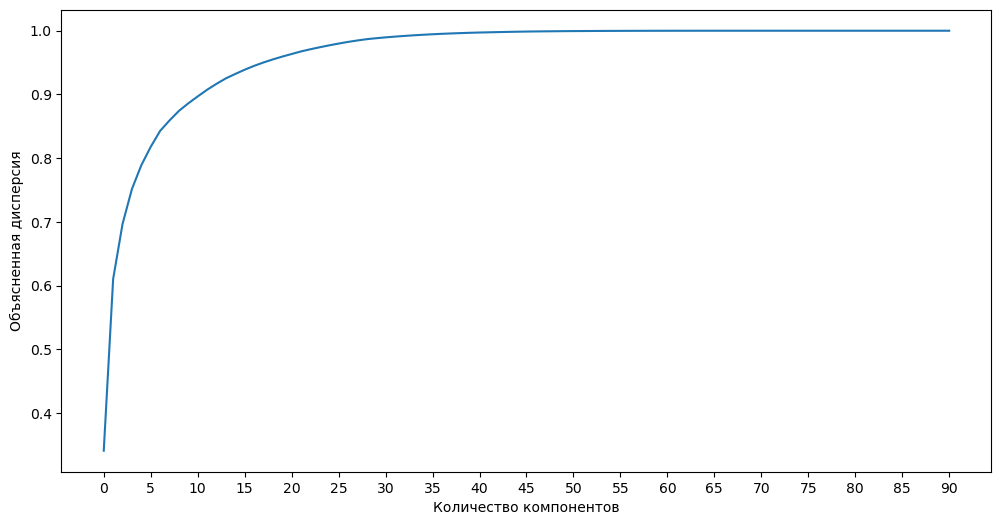

In [22]:
plt.figure(figsize=(12, 6))  # Устанавливаем размер фигуры

pca = PCA().fit(X_train_scaled)
n_components = pca.explained_variance_ratio_.shape[0]

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xticks(np.arange(0, n_components + 1, step=5))  # Устанавливаем шаг на оси X
plt.xlabel('Количество компонентов')
plt.ylabel('Объясненная дисперсия')
plt.show()

In [41]:
# Установим важные компоненты:
components = 40

# Применим преобразование метода главных компонент 
# к стандартизированным данным, 
# уменьшая их размерность до количества компонент(десяти)

pca = PCA(n_components=components)
X_pca_train = pca.fit_transform(X_train_scaled)
X_pca_test = pca.fit_transform(X_test_scaled)

# Вычисление дисперсии, объясненной главными компонентами
print("Дисперсия каждой компоненты: ", pca.explained_variance_ratio_)
print("\n Общая объясненная дисперсия: ", round(sum(list(pca.explained_variance_ratio_)) * 100, 2))

Дисперсия каждой компоненты:  [4.54317840e-01 1.54084364e-01 7.53463476e-02 5.86870206e-02
 4.74512815e-02 3.81870500e-02 3.22728993e-02 2.32107499e-02
 2.11000061e-02 1.31322113e-02 1.18453531e-02 1.13002485e-02
 9.33118612e-03 8.05885991e-03 6.25768065e-03 5.21323053e-03
 4.10728089e-03 3.86334762e-03 3.40084266e-03 3.05813347e-03
 2.53739322e-03 1.96415094e-03 1.84519828e-03 1.48021384e-03
 1.42279860e-03 1.19789762e-03 8.12063126e-04 7.55154117e-04
 7.03737385e-04 5.95945193e-04 4.55278500e-04 3.68593807e-04
 2.99362233e-04 2.65620209e-04 2.24729733e-04 1.89895810e-04
 1.26527962e-04 1.11802476e-04 7.44370242e-05 6.47953769e-05]

 Общая объясненная дисперсия:  99.97


In [42]:
# Определение метрик для оценки
scoring = {'precision': make_scorer(precision_score, average='weighted'),
           'recall': make_scorer(recall_score, average='weighted'),
           'f1_score': make_scorer(f1_score, average='weighted'),
           'accuracy': make_scorer(accuracy_score)}

# Инициализация модели
model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=5)

# Создание стратифицированных фолдов
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Выполнение кросс-валидации с оценкой
cv_results = cross_validate(model, X_pca_train, y_train, cv=skf, scoring=scoring)

# Вычисление средних значений метрик
avg_precision = np.mean(cv_results['test_precision'])
avg_recall = np.mean(cv_results['test_recall'])
avg_f1_score = np.mean(cv_results['test_f1_score'])
avg_accuracy = np.mean(cv_results['test_accuracy'])

# Вычисление среднего времени обучения
avg_train_time = np.mean(cv_results['fit_time'])

# Вывод результатов
print("Среднее значение precision на кросс-валидации:", avg_precision)
print("Среднее значение recall на кросс-валидации:", avg_recall)
print("Среднее значение F1-score на кросс-валидации:", avg_f1_score)
print("Среднее значение accuracy на кросс-валидации:", avg_accuracy)
print("Среднее время обучения на одну модель:",avg_train_time, "секунд")

Среднее значение precision на кросс-валидации: 0.509411315801078
Среднее значение recall на кросс-валидации: 0.5110361204849394
Среднее значение F1-score на кросс-валидации: 0.5085953361990186
Среднее значение accuracy на кросс-валидации: 0.5110361204849394
Среднее время обучения на одну модель: 0.2545574188232422 секунд


In [43]:
from sklearn.metrics import classification_report

# Обучаем модель
model.fit(X_pca_train, y_train)

# Прогнозирование меток классов для тестовых данных
y_train_pred = model.predict(X_pca_train)
y_test_pred = model.predict(X_pca_test)

# Вывод отчета классификации
print('Прогнозирование меток классов для тренировочных данных:', classification_report(y_train, y_train_pred), sep='\n')
print('---' * 20)
print('Прогнозирование меток классов для тестовых данных:', classification_report(y_test, y_test_pred), sep='\n')


Прогнозирование меток классов для тренировочных данных:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95       304
           1       0.93      0.97      0.95       330

    accuracy                           0.95       634
   macro avg       0.95      0.95      0.95       634
weighted avg       0.95      0.95      0.95       634

------------------------------------------------------------
Прогнозирование меток классов для тестовых данных:
              precision    recall  f1-score   support

           0       0.50      0.61      0.55        69
           1       0.64      0.53      0.58        90

    accuracy                           0.57       159
   macro avg       0.57      0.57      0.57       159
weighted avg       0.58      0.57      0.57       159



В этом случае метод главных компонет показывает результаты хуже, чем без него.